## Importations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from src.params import SUBJ_CLEAN, RESULT_PATH, ACTIVE_RUN, PASSIVE_RUN, FIG_PATH, FREQS_LIST, PREPROC_PATH, FREQS_NAMES
from src.utils import get_bids_file
import os
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

import mne
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.viz import plot_compare_evokeds

## Prepare data

In [2]:
task = 'LaughterActive'
subj_list = SUBJ_CLEAN
stage = "epo"

# Select what conditions to compute (str)
cond1 = 'Good'
cond2 = 'BaselineZero'
cond3 = 'Miss'

if cond1 == 'Good' and 'cond3' == 'Miss' :
    button_cond = True
else :
    button_cond = False
    
conditions = conditions = cond1 + '-' + cond2
condition_list = [cond1, cond2]
picks = "meg" # Select MEG channels

roi = 'MLT'

In [44]:
# Import data

contrasts_all_subject = []
contrasts_all_subject_all_chan = []

evoked_baseline = []
evoked_condition1 = []

evoked_baseline_data = []
evoked_condition1_data = []

for subj in SUBJ_CLEAN :
    print("processing -->", subj)
    
    chan_selected = []
    
    # Load epochs data
    _, path_epochs = get_bids_file(RESULT_PATH, task=task, subj=subj, stage="AR_epo")
    epochs = mne.read_epochs(path_epochs, verbose=None)
    epochs.apply_baseline(baseline=(None, 0))
    
    CHAN = epochs.info['ch_names']
    
    # Select channel of interest
    for chan in CHAN  : 
        if roi in chan : 
            chan_selected.append(chan)
    
    epochs_copy = epochs.copy() 
    epochs_copy.pick_channels(chan_selected)
            
    
    # Create fake evoked with value=0 
    baseline_data = np.zeros((epochs_copy.get_data().shape[1], epochs_copy.get_data().shape[2]))
    baseline_roi = mne.EvokedArray(baseline_data, epochs_copy.info, tmin=-0.5, comment='baseline')
    
    baseline_data_all_chan = np.zeros((epochs.get_data().shape[1], epochs.get_data().shape[2]))
    baseline_all_chan = mne.EvokedArray(baseline_data_all_chan, epochs.info, tmin=-0.5, comment='baseline')
    
    
    if button_cond == True : # Compute button press : Combine events Good & Bad
        evoked_cond1_roi = mne.combine_evoked([epochs_copy[cond1].average(), epochs_copy[cond3].average()], weights='nave')
        evoked_cond1_all_chan = mne.combine_evoked([epochs[cond1].average(), epochs[cond3].average()], weights='nave')

    else : # For other conditions
        evoked_cond1_roi = epochs_copy[cond1].average()
        evoked_cond1_all_chan = epochs[cond1].average()

    # Prepare data for ttest with roi
    evoked_baseline_data.append(baseline_roi.get_data()) 
    evoked_condition1_data.append(evoked_cond1_roi.get_data())
    
    evoked_baseline.append(baseline_roi) 
    evoked_condition1.append(evoked_cond1_roi)
    
# Combine all subject together
evokeds = {cond1 : evoked_condition1, cond2 : evoked_baseline}


processing --> 01
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
296 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-02/sub-02_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
295 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-03/sub-03_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of in

Adding metadata with 7 columns
300 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 22
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-22/sub-22_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
298 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 23
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-23/sub-23_task-LaughterActive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
185 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
proce

## Perform paired t-test

In [73]:
# Perform t-test without correction without clusters
cond1_data = np.array(evoked_condition1_data)
cond2_data = np.array(evoked_baseline_data)
print(cond1_data.shape)
print(cond2_data.shape)

# Average signal across channel
cond1_data_ave = np.transpose(np.mean(cond1_data, axis=1), [1, 0])
cond2_data_ave = np.transpose(np.mean(cond2_data, axis=1), [1, 0])

print(cond1_data_ave.shape)
print(cond2_data_ave.shape)

report = "time={i_ti}, t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")

p_vals = []
x_time = []

for i_ti, ti in enumerate(cond1_data_ave):

    data1 = cond1_data_ave[i_ti, :]
    data2 = cond2_data_ave[i_ti, :]

    # conduct t test
    t, p = ttest_rel(data1, data2, axis=None) # Paired t-test

    p_vals.append(p)
    x_time.append(i_ti)

    # display results
    format_dict = dict(
        i_ti=evoked_cond1_roi.times[i_ti], df=len(cond1_arr) - 1, t_val=t, p=p
    )
    print(report.format(**format_dict))

(27, 34, 2401)
(27, 34, 2401)
(2401, 27)
(2401, 27)

Targeted statistical test results:
time=-0.5, t(26)=-3.514, p=0.002
time=-0.49916666666666665, t(26)=-3.487, p=0.002
time=-0.49833333333333335, t(26)=-3.398, p=0.002
time=-0.4975, t(26)=-3.297, p=0.003
time=-0.49666666666666665, t(26)=-3.222, p=0.003
time=-0.49583333333333335, t(26)=-3.188, p=0.004
time=-0.495, t(26)=-3.189, p=0.004
time=-0.49416666666666664, t(26)=-3.216, p=0.003
time=-0.49333333333333335, t(26)=-3.260, p=0.003
time=-0.4925, t(26)=-3.306, p=0.003
time=-0.49166666666666664, t(26)=-3.335, p=0.003
time=-0.49083333333333334, t(26)=-3.343, p=0.003
time=-0.49, t(26)=-3.357, p=0.002
time=-0.4891666666666667, t(26)=-3.417, p=0.002
time=-0.48833333333333334, t(26)=-3.528, p=0.002
time=-0.4875, t(26)=-3.646, p=0.001
time=-0.4866666666666667, t(26)=-3.703, p=0.001
time=-0.48583333333333334, t(26)=-3.678, p=0.001
time=-0.485, t(26)=-3.603, p=0.001
time=-0.4841666666666667, t(26)=-3.538, p=0.002
time=-0.48333333333333334, t(26)=

In [74]:
# Select pvalues sig.
pval_corrected = 0.01/len(np.transpose(cond1_data_ave, [1, 0])) #Number of time point
pval_plot = []
time_plot = []

for i, pval in enumerate(p_vals) : 
    if pval < pval_corrected :
        pval_plot.append(pval)
        time_plot.append(evoked_cond1_roi.times[i])

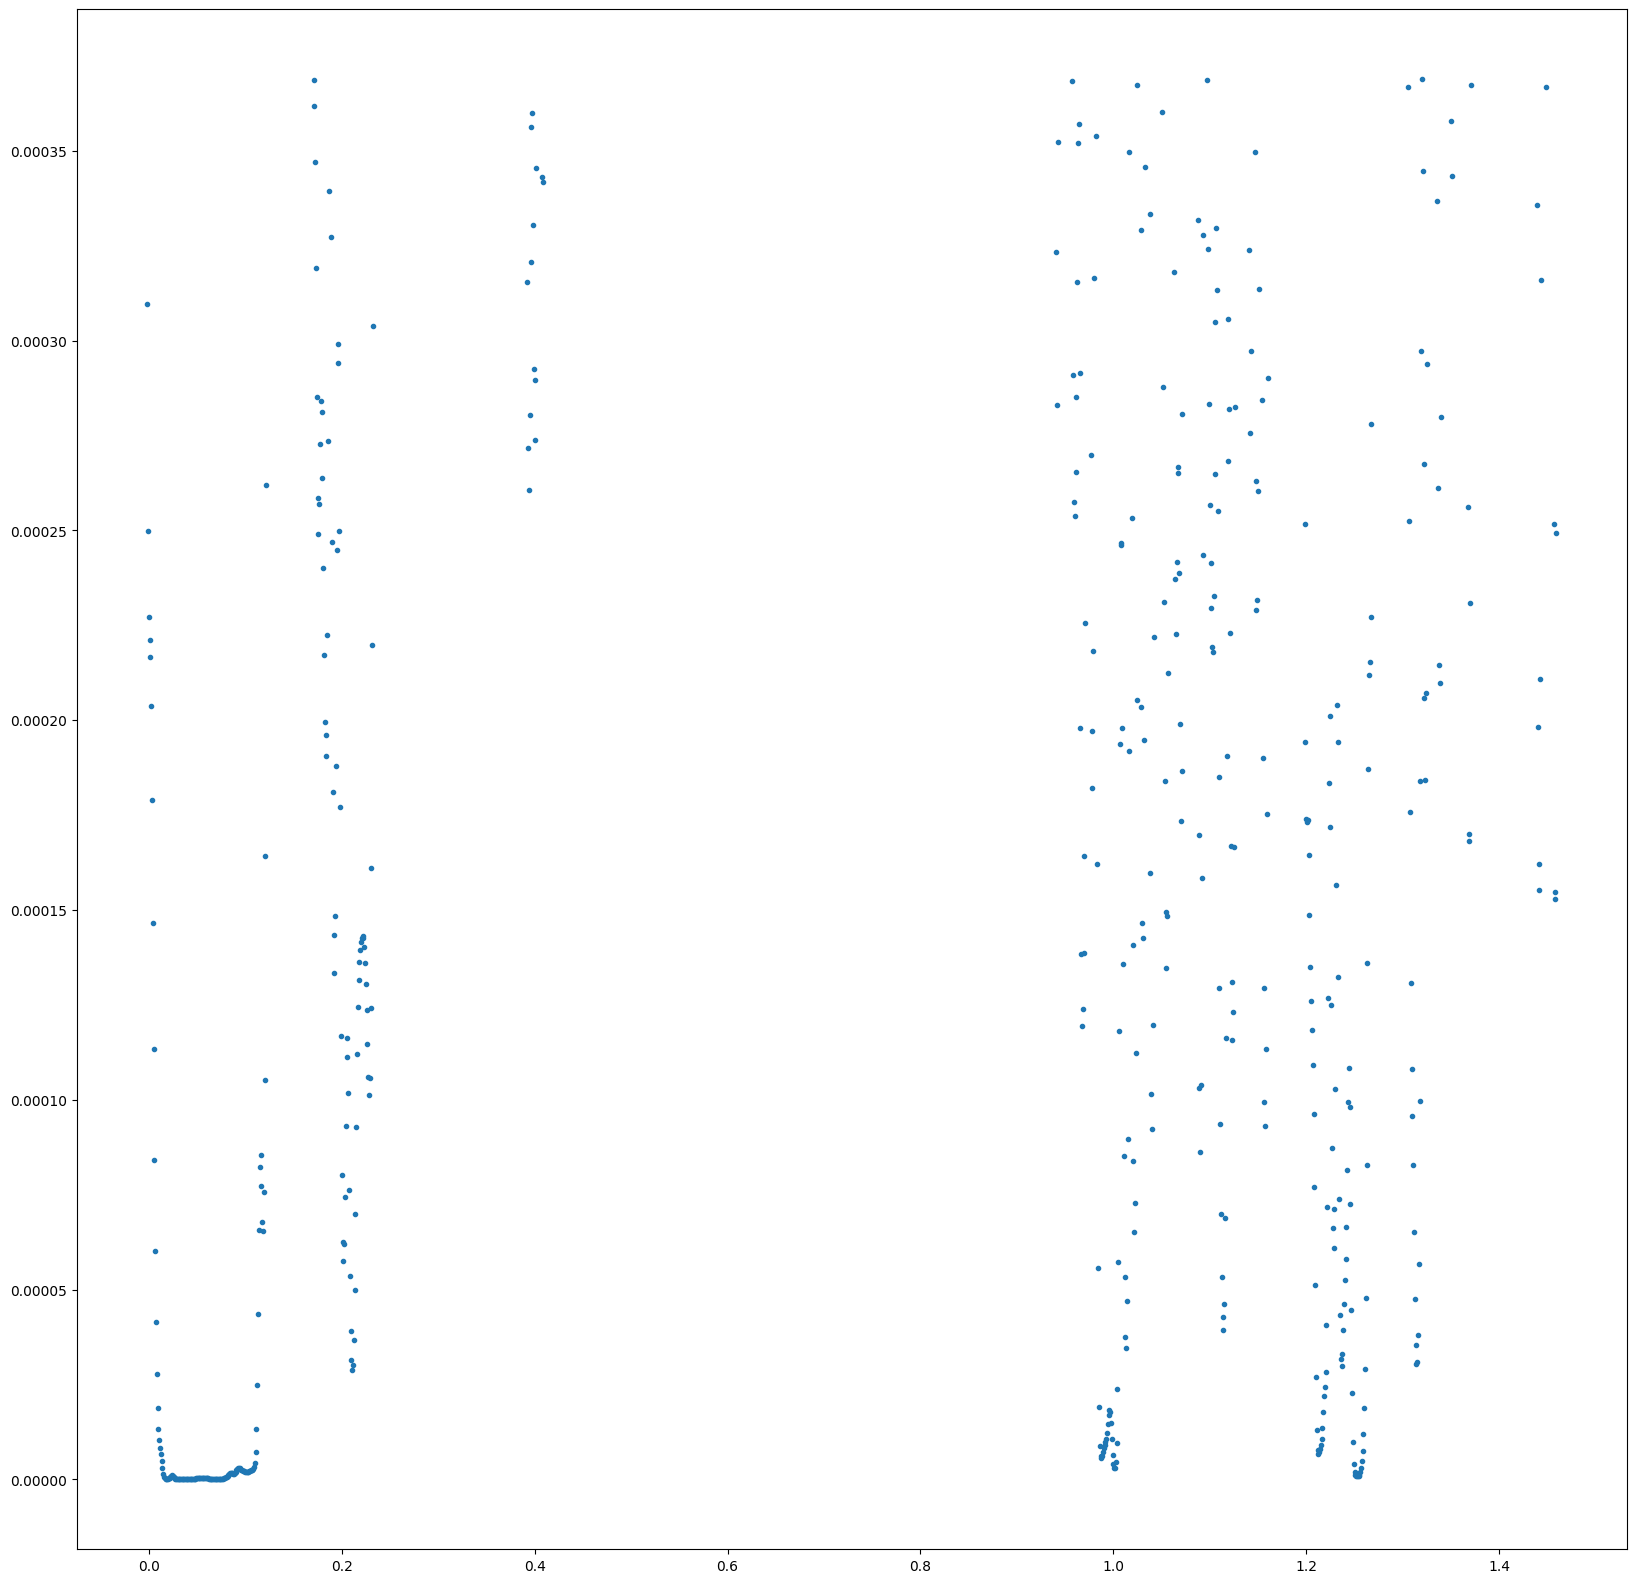

In [80]:
# Plot pvals sig through time
#time = np.arange(0, 1500, 200)
#ticks_label = ['-200','0', '200', '400', '600', '800', '1000', '1200']

y = np.array(pval_plot)
x_plot = np.array(time_plot)

fig, ax = plt.subplots(1, figsize=(20, 20))
plt.plot(x_plot, y, marker='.', linestyle='None')
#plt.xticks(ticks = time, labels = ticks_label)
#plt.axvline(x = 200, color = 'black', linestyle = 'dashed', linewidth=0.5)
plt.show()

## Plot

combining channels using "mean"
combining channels using "mean"


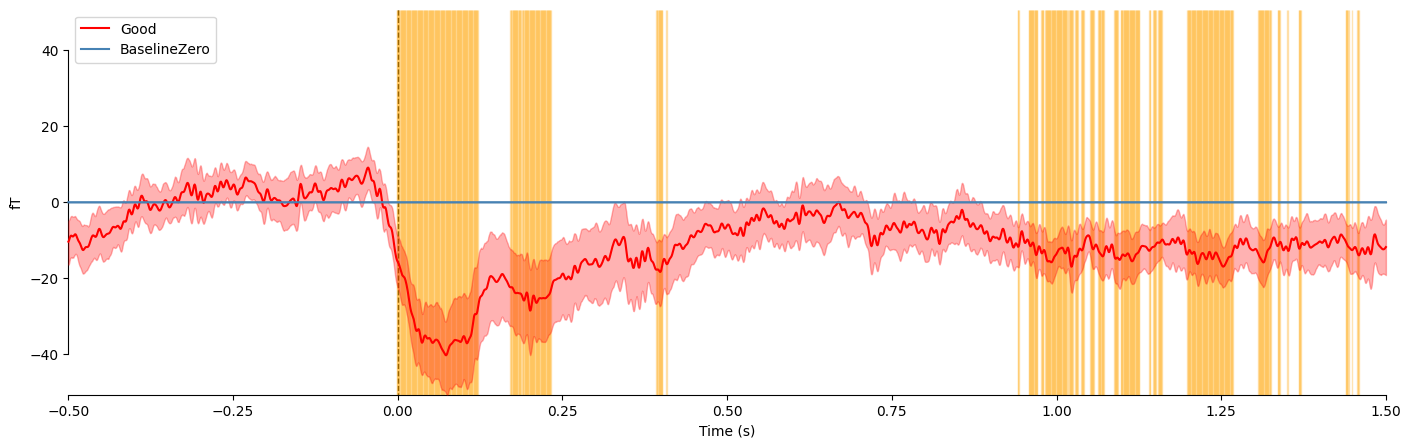

In [81]:
colors = "r",'steelblue'

fig, ax = plt.subplots(1, 1, figsize=(17, 5))

plot_compare_evokeds(evokeds,
                colors=colors, show=False, axes=ax,
                split_legend=True, truncate_yaxis='auto', combine="mean")

for i, val in enumerate(pval_plot):
    sig_times = []
    
    # plot temporal cluster extent
    sig_times.append(time_plot[i])
    ymin, ymax = ax.get_ylim()
    ax.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                        color='orange', alpha=0.3)
plt.show()